In [1]:
# Install packages if needed (run only once in Jupyter/Colab/Mac)
!pip install tensorflow-macos
!pip install tensorflow-metal

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import json
import os

# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.framework import ops
print(ops.get_default_graph())
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    print("✅ Using GPU")
else:
    print("❌ No GPU found")

# Dataset paths
train_path = "Downloads/Plants/train"
valid_path = "Downloads/Plants/valid"

# Load datasets
training_set = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    valid_path,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True
)

class_names = training_set.class_names
print("Class names:", class_names)

# Normalize images
normalization_layer = tf.keras.layers.Rescaling(1./255)

training_set = training_set.map(lambda x, y: (normalization_layer(x), y))
validation_set = validation_set.map(lambda x, y: (normalization_layer(x), y))

# Data Augmentation
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras import Sequential as KerasSequential

data_augmentation = KerasSequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.1),
])

# Apply augmentation
training_set = training_set.map(lambda x, y: (data_augmentation(x, training=True), y))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
training_set = training_set.prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.prefetch(buffer_size=AUTOTUNE)

# Improved CNN architecture
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),

    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
cnn.summary()

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1
)

# Train the model
history = cnn.fit(
    training_set,
    validation_data=validation_set,
    epochs=30,
    callbacks=[checkpoint, earlystop]
)

# Final evaluation
train_loss, train_acc = cnn.evaluate(training_set)
print("✅ Training accuracy:", train_acc)

val_loss, val_acc = cnn.evaluate(validation_set)
print("✅ Validation accuracy:", val_acc)

# Save final model
cnn.save('trained_plant_disease_model11.keras')

# Save training history
with open('training_hist.json', 'w') as f:
    json.dump(history.history, f)

print("✅ Model and training history saved.")




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Num GPUs Available:  1
✅ Using GPU
Found 70295 files belonging to 38 classes.


2025-06-08 07:42:23.065880: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-06-08 07:42:23.065947: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-08 07:42:23.065952: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-08 07:42:23.066009: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-08 07:42:23.066027: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 17572 files belonging to 38 classes.
Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Sp

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 63, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 374,342 (1.43 MB)

 Trainable params: 373,446 (1.42 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/30


2025-06-08 07:42:24.517564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-06-08 07:42:24.536136: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.4272 - loss: 2.1162

2025-06-08 08:00:28.403272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 1: val_accuracy improved from -inf to 0.48799, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1139s 517ms/step - accuracy: 0.4273 - loss: 2.1159 - val_accuracy: 0.4880 - val_loss: 1.8733
Epoch 2/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7707 - loss: 0.7501

2025-06-08 08:48:43.991001: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 2: val_accuracy improved from 0.48799 to 0.57979, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2890s 1s/step - accuracy: 0.7707 - loss: 0.7500 - val_accuracy: 0.5798 - val_loss: 1.6480
Epoch 3/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.8541 - loss: 0.4740

2025-06-08 09:06:02.695468: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 3: val_accuracy improved from 0.57979 to 0.65917, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1048s 477ms/step - accuracy: 0.8541 - loss: 0.4740 - val_accuracy: 0.6592 - val_loss: 1.2860
Epoch 4/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.8929 - loss: 0.3437

2025-06-08 09:31:13.247105: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 4: val_accuracy did not improve from 0.65917
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1501s 683ms/step - accuracy: 0.8929 - loss: 0.3436 - val_accuracy: 0.6509 - val_loss: 1.4462
Epoch 5/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9163 - loss: 0.2631

2025-06-08 09:47:00.481837: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 5: val_accuracy improved from 0.65917 to 0.78249, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 949s 432ms/step - accuracy: 0.9163 - loss: 0.2631 - val_accuracy: 0.7825 - val_loss: 0.7398
Epoch 6/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9323 - loss: 0.2150

2025-06-08 10:02:49.005731: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 6: val_accuracy did not improve from 0.78249
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 947s 431ms/step - accuracy: 0.9323 - loss: 0.2150 - val_accuracy: 0.7477 - val_loss: 0.9012
Epoch 7/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9432 - loss: 0.1833

2025-06-08 10:18:39.687313: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 7: val_accuracy improved from 0.78249 to 0.79445, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 951s 433ms/step - accuracy: 0.9432 - loss: 0.1833 - val_accuracy: 0.7944 - val_loss: 0.7380
Epoch 8/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9476 - loss: 0.1645

2025-06-08 10:34:43.207572: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 8: val_accuracy did not improve from 0.79445
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 963s 438ms/step - accuracy: 0.9476 - loss: 0.1645 - val_accuracy: 0.7407 - val_loss: 1.0148
Epoch 9/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9576 - loss: 0.1341

2025-06-08 10:50:32.729973: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 9: val_accuracy improved from 0.79445 to 0.82170, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 950s 432ms/step - accuracy: 0.9576 - loss: 0.1341 - val_accuracy: 0.8217 - val_loss: 0.6109
Epoch 10/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9613 - loss: 0.1213

2025-06-08 11:06:52.354500: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 10: val_accuracy did not improve from 0.82170
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 979s 446ms/step - accuracy: 0.9613 - loss: 0.1212 - val_accuracy: 0.7643 - val_loss: 0.8898
Epoch 11/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9668 - loss: 0.1087

2025-06-08 11:23:21.487039: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 11: val_accuracy did not improve from 0.82170
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 994s 453ms/step - accuracy: 0.9668 - loss: 0.1087 - val_accuracy: 0.8201 - val_loss: 0.6237
Epoch 12/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9697 - loss: 0.0975

2025-06-08 11:39:17.644378: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 12: val_accuracy did not improve from 0.82170
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 951s 433ms/step - accuracy: 0.9697 - loss: 0.0975 - val_accuracy: 0.7724 - val_loss: 0.8627
Epoch 13/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9726 - loss: 0.0884

2025-06-08 11:55:04.189677: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 13: val_accuracy improved from 0.82170 to 0.87366, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 949s 432ms/step - accuracy: 0.9726 - loss: 0.0884 - val_accuracy: 0.8737 - val_loss: 0.4247
Epoch 14/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9747 - loss: 0.0813

2025-06-08 12:10:56.234334: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 14: val_accuracy improved from 0.87366 to 0.87924, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 956s 435ms/step - accuracy: 0.9747 - loss: 0.0813 - val_accuracy: 0.8792 - val_loss: 0.3829
Epoch 15/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9741 - loss: 0.0783

2025-06-08 12:26:57.342585: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 15: val_accuracy improved from 0.87924 to 0.89893, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 956s 435ms/step - accuracy: 0.9741 - loss: 0.0783 - val_accuracy: 0.8989 - val_loss: 0.3250
Epoch 16/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9775 - loss: 0.0720

2025-06-08 12:42:46.470669: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 16: val_accuracy improved from 0.89893 to 0.90052, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 949s 432ms/step - accuracy: 0.9775 - loss: 0.0720 - val_accuracy: 0.9005 - val_loss: 0.3208
Epoch 17/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9780 - loss: 0.0688

2025-06-08 12:58:55.521123: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 17: val_accuracy did not improve from 0.90052
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 969s 441ms/step - accuracy: 0.9780 - loss: 0.0688 - val_accuracy: 0.8990 - val_loss: 0.3416
Epoch 18/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9787 - loss: 0.0658

2025-06-08 13:14:57.769021: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 18: val_accuracy did not improve from 0.90052
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 962s 438ms/step - accuracy: 0.9787 - loss: 0.0658 - val_accuracy: 0.8857 - val_loss: 0.4068
Epoch 19/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9813 - loss: 0.0601

2025-06-08 13:30:49.887498: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 19: val_accuracy improved from 0.90052 to 0.92676, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 952s 433ms/step - accuracy: 0.9813 - loss: 0.0601 - val_accuracy: 0.9268 - val_loss: 0.2445
Epoch 20/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9821 - loss: 0.0560

2025-06-08 13:46:47.638338: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 20: val_accuracy did not improve from 0.92676
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 958s 436ms/step - accuracy: 0.9821 - loss: 0.0560 - val_accuracy: 0.9207 - val_loss: 0.2738
Epoch 21/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9821 - loss: 0.0559

2025-06-08 14:03:11.827888: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 21: val_accuracy did not improve from 0.92676
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 985s 448ms/step - accuracy: 0.9821 - loss: 0.0559 - val_accuracy: 0.8569 - val_loss: 0.6092
Epoch 22/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9830 - loss: 0.0519

2025-06-08 14:20:38.097545: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 22: val_accuracy did not improve from 0.92676
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1046s 476ms/step - accuracy: 0.9830 - loss: 0.0519 - val_accuracy: 0.9088 - val_loss: 0.3074
Epoch 23/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9845 - loss: 0.0482

2025-06-08 14:36:35.273788: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 23: val_accuracy improved from 0.92676 to 0.93700, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 957s 435ms/step - accuracy: 0.9845 - loss: 0.0482 - val_accuracy: 0.9370 - val_loss: 0.2047
Epoch 24/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9848 - loss: 0.0455

2025-06-08 14:52:25.171995: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 24: val_accuracy did not improve from 0.93700
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 952s 433ms/step - accuracy: 0.9848 - loss: 0.0455 - val_accuracy: 0.9335 - val_loss: 0.2217
Epoch 25/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9862 - loss: 0.0421

2025-06-08 15:08:31.502017: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 25: val_accuracy did not improve from 0.93700
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 964s 439ms/step - accuracy: 0.9862 - loss: 0.0421 - val_accuracy: 0.8953 - val_loss: 0.3769
Epoch 26/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9855 - loss: 0.0432

2025-06-08 15:24:25.898161: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 26: val_accuracy did not improve from 0.93700
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 954s 434ms/step - accuracy: 0.9855 - loss: 0.0432 - val_accuracy: 0.9002 - val_loss: 0.3758
Epoch 27/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9860 - loss: 0.0419

2025-06-08 15:41:46.950037: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 27: val_accuracy improved from 0.93700 to 0.93905, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1042s 474ms/step - accuracy: 0.9860 - loss: 0.0419 - val_accuracy: 0.9391 - val_loss: 0.1882
Epoch 28/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9875 - loss: 0.0378

2025-06-08 15:57:47.525036: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 28: val_accuracy improved from 0.93905 to 0.96847, saving model to best_model.keras
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 967s 440ms/step - accuracy: 0.9875 - loss: 0.0378 - val_accuracy: 0.9685 - val_loss: 0.0973
Epoch 29/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9873 - loss: 0.0391

2025-06-08 16:14:11.709224: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 29: val_accuracy did not improve from 0.96847
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 978s 445ms/step - accuracy: 0.9873 - loss: 0.0391 - val_accuracy: 0.9391 - val_loss: 0.2116
Epoch 30/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9872 - loss: 0.0383

2025-06-08 16:30:22.588294: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 30: val_accuracy did not improve from 0.96847
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 970s 442ms/step - accuracy: 0.9872 - loss: 0.0383 - val_accuracy: 0.8757 - val_loss: 0.4789
Restoring model weights from the end of the best epoch: 28.
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 254s 115ms/step - accuracy: 0.9913 - loss: 0.0250
✅ Training accuracy: 0.9921189546585083
  2/550 ━━━━━━━━━━━━━━━━━━━━ 36s 67ms/step - accuracy: 0.9531 - loss: 0.1325

2025-06-08 16:35:27.422391: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


550/550 ━━━━━━━━━━━━━━━━━━━━ 54s 99ms/step - accuracy: 0.9674 - loss: 0.0996
✅ Validation accuracy: 0.9684725403785706
✅ Model and training history saved.


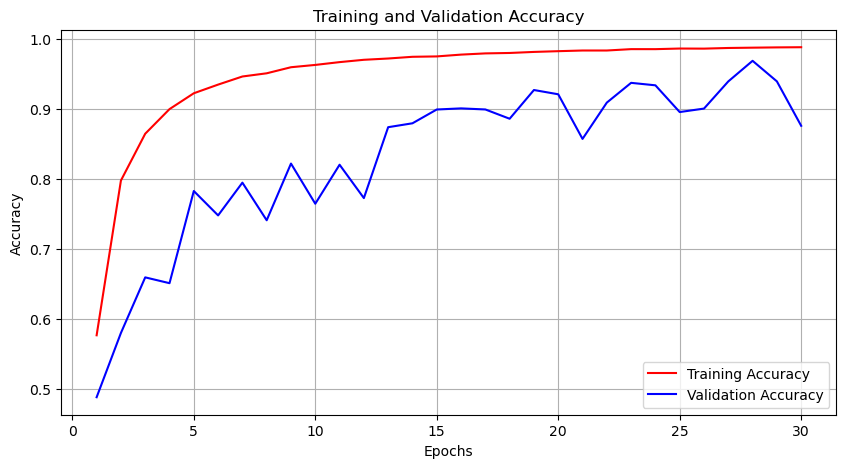

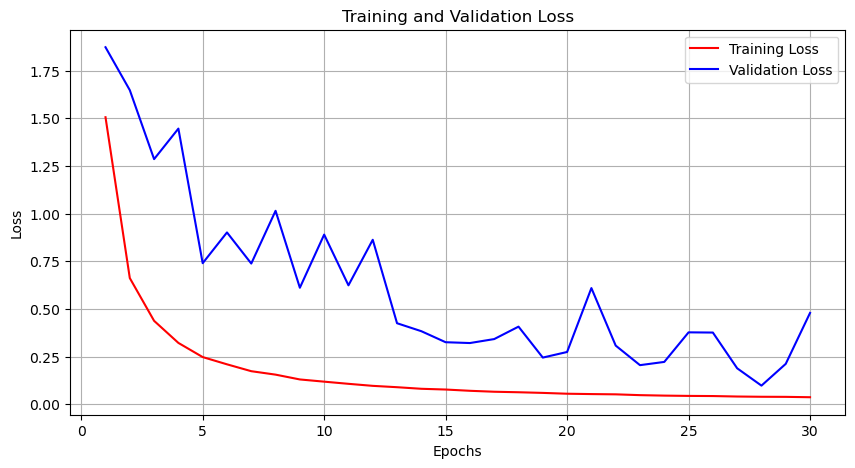

In [3]:
import json
import matplotlib.pyplot as plt
%matplotlib inline

# Load saved training history
with open('training_hist.json', 'r') as f:
    history_data = json.load(f)

# Define the range of epochs
epochs = range(1, len(history_data['accuracy']) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, history_data['accuracy'], 'r-', label='Training Accuracy')
plt.plot(epochs, history_data['val_accuracy'], 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, history_data['loss'], 'r-', label='Training Loss')
plt.plot(epochs, history_data['val_loss'], 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Define the path to your validation set
valid_path = "Downloads/Plants/valid"

# Load validation dataset with batch_size=1 and no shuffling
test_set_raw = tf.keras.utils.image_dataset_from_directory(
    valid_path,
    labels="inferred",
    label_mode="categorical",
    batch_size=1,
    image_size=(128, 128),
    shuffle=False
)

# Save class names BEFORE applying any transformations
class_names = test_set_raw.class_names

# Normalize images
normalization_layer = tf.keras.layers.Rescaling(1./255)
test_set = test_set_raw.map(lambda x, y: (normalization_layer(x), y))

# Load trained model
cnn = keras.models.load_model('trained_plant_disease_model11.keras')

# Predict class probabilities
y_pred = cnn.predict(test_set)

# Convert predicted probabilities to class indices
predicted_categories = tf.argmax(y_pred, axis=1).numpy()

# Extract true labels
true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1).numpy()

# Generate confusion matrix
cm = confusion_matrix(Y_true, predicted_categories)
print("✅ Confusion Matrix:\n", cm)

# Generate classification report
print("\n✅ Classification Report:\n")
print(classification_report(Y_true, predicted_categories, target_names=class_names))




Found 17572 files belonging to 38 classes.


2025-06-17 00:19:03.396730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-06-17 00:19:03.413189: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


17572/17572 ━━━━━━━━━━━━━━━━━━━━ 107s 6ms/step


2025-06-17 00:21:17.769395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


✅ Confusion Matrix:
 [[483   0   0 ...   0   0   0]
 [  0 492   0 ...   0   0   0]
 [  0   0 433 ...   0   0   0]
 ...
 [  0   0   0 ... 481   0   0]
 [  0   0   0 ...   0 447   0]
 [  0   0   0 ...   0   0 463]]

✅ Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.96      0.98       504
                                 Apple___Black_rot       1.00      0.99      0.99       497
                          Apple___Cedar_apple_rust       0.99      0.98      0.99       440
                                   Apple___healthy       0.92      0.98      0.95       502
                               Blueberry___healthy       1.00      0.98      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.98      0.99       421
                 Cherry_(including_sour)___healthy       1.00      0.99      0.99       456
Corn_(maize)___Cercospo

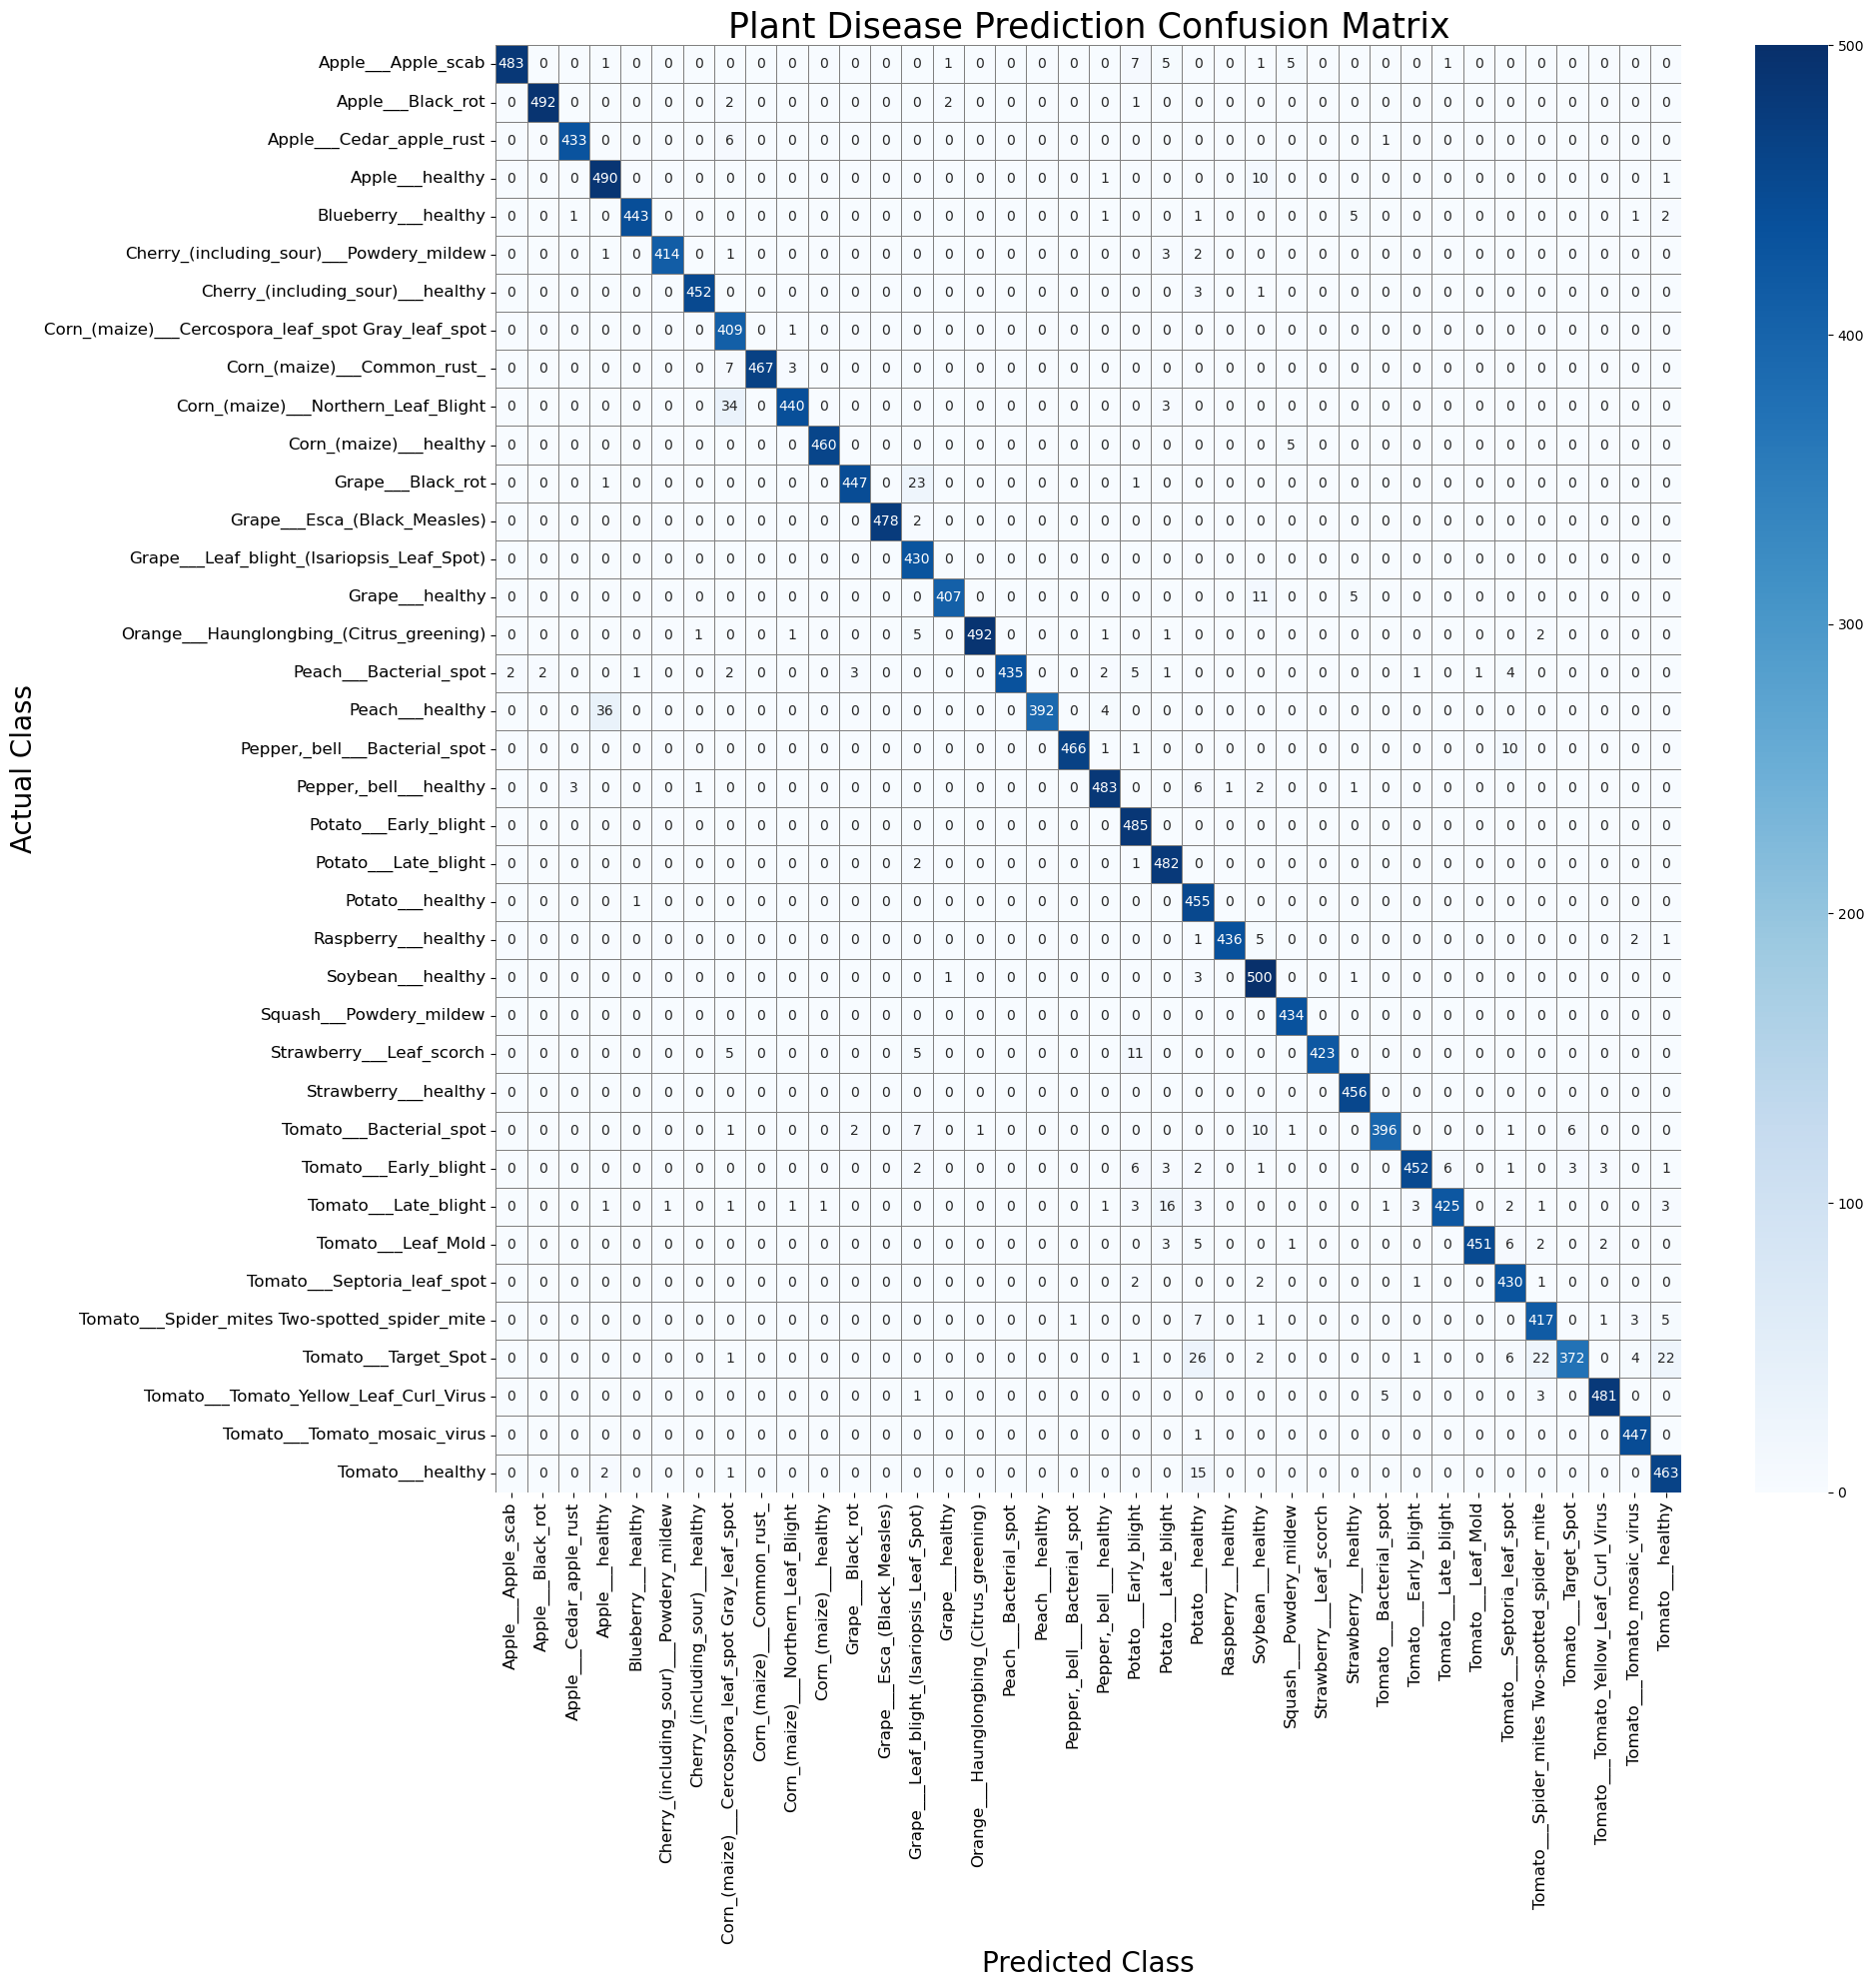

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure cm and class_names are defined from earlier steps
plt.figure(figsize=(20, 20))  # You can adjust size if needed

sns.heatmap(cm, 
            annot=True, 
            annot_kws={"size": 10}, 
            cmap='Blues', 
            fmt='g', 
            linewidths=0.5, 
            linecolor='gray')

plt.xlabel('Predicted Class', fontsize=20)
plt.ylabel('Actual Class', fontsize=20)
plt.title('Plant Disease Prediction Confusion Matrix', fontsize=25)

plt.xticks(ticks=np.arange(len(class_names)) + 0.5, 
           labels=class_names, 
           rotation=90, 
           fontsize=12)

plt.yticks(ticks=np.arange(len(class_names)) + 0.5, 
           labels=class_names, 
           rotation=0, 
           fontsize=12)

plt.tight_layout()
plt.show()
